#### Data import

In [1]:
import pandas as pd

train_df = pd.read_csv('../data/cleaned_train.csv')
test_df = pd.read_csv('../data/cleaned_test.csv')

#### Model import
I tried XGBoost and LGBM

In [2]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

Checking dataframe

In [3]:
train_df

,season,holiday,workingday,weather,temp,humidity,windspeed,count,date,hours
0,1,0,0,1,9.84,81,0.0000,16,0,0
1,1,0,0,1,9.02,80,0.0000,40,0,1
2,1,0,0,1,9.02,80,0.0000,32,0,2
3,1,0,0,1,9.84,75,0.0000,13,0,3
4,1,0,0,1,9.84,75,0.0000,1,0,4
...,...,...,...,...,...,...,...,...,...,...
8603,3,0,1,1,33.62,49,11.0014,505,565,20
8604,3,0,1,3,27.06,89,16.9979,332,565,21
8605,3,0,1,3,27.06,89,16.9979,68,565,22
8606,3,0,1,3,27.06,89,15.0013,65,565,23


I tried oHe with season but the score was worst

In [4]:
xgb = XGBRegressor(alpha = 10, gamma = 5, learning_rate = 0.05, n_estimators = 200)

Pretty low learning rate, i tried different number a estimators and 200 was generally the best, alpha at 10 : L1 regularization term on weights,
Gamma at 5 : specifies the minimum loss reduction required to make a split.

#### Train, test split

In [5]:
y_train = train_df['count']
X_train = train_df.drop('count', axis=1)
y_test = test_df['count']
X_test = test_df.drop('count', axis=1)

#### XGBoost Scores

In [6]:
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

train_score = xgb.score(X_train, y_train)
r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred, squared=True)
rmse = mean_squared_error(y_test, pred, squared=False)
mape = mean_absolute_percentage_error(y_test, pred)

print(f'Train r2 score: ', train_score, '\n'
      'Test: ', '\n'
      ' - r2 score: ',  r2, '\n'
      ' - mae: ',  mae, '\n'
      ' - mse: ',  mse, '\n'
      ' - rmse: ',  rmse, '\n'
      ' - mape: ',  mape, '\n'
      )

Train r2 score:  0.9693490775973694 
Test:  
 - r2 score:  0.9073174669582437 
 - mae:  45.10766438572958 
 - mse:  4401.119458861249 
 - rmse:  66.34093350911826 
 - mape:  0.37048909309619144 



In [7]:
from sklearn.model_selection import learning_curve, StratifiedKFold, cross_val_score
import numpy as np

skf = StratifiedKFold(n_splits=10)
print(f'Cross val score: ', np.mean(cross_val_score(xgb, X_train, y_train, cv=skf)))

C:\Users\Apprenant\anaconda3\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Cross val score:  0.9433874577508565


C:\Users\Apprenant\anaconda3\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


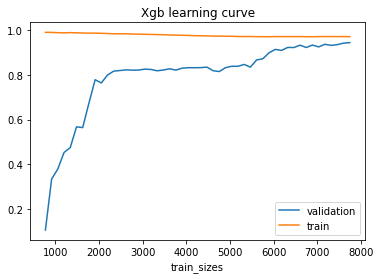

In [8]:
import matplotlib.pyplot as plt


N, train_score, val_score = learning_curve(xgb, X_train, y_train, train_sizes = np.linspace(0.1,1,50), cv=skf, scoring='r2')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.plot(N, train_score.mean(axis=1), label='train')

plt.xlabel('train_sizes')
plt.title('Xgb learning curve')
plt.legend()
plt.show() 

In [9]:
import pickle
pickle.dump(xgb, open('xgb_best.pkl', 'wb'))

In [15]:
from sklearn.ensemble import StackingRegressor

estimators = [
    ('xgb1', XGBRegressor(booster = "gbtree",
                        colsample_bytree = 0.6,
                        eta= 0.4,
                        gamma= 0.1,
                        max_depth= 10,
                        max_leaves= 31,
                        n_estimators= 50,
                        objective= "reg:linear",
                        reg_alpha= 0,
                        reg_lambda= 0.625,
                        subsample= 0.8,
                        tree_method= "auto")),
    ('xgb2', XGBRegressor(booster = "gbtree",
                        colsample_bytree = 0.9,
                        eta = 0.5,
                        gamma = 0.01,
                        max_depth = 8,
                        max_leaves = 0,
                        n_estimators = 50,
                        objective = "reg:linear",
                        reg_alpha = 1.3541666666666667,
                        reg_lambda = 1.6666666666666667,
                        subsample = 1,
                        tree_method = "auto")),
    ('xgb3', XGBRegressor(booster = "gbtree",
                        colsample_bytree = 0.5,
                        eta = 0.3,
                        gamma = 0,
                        max_depth = 6,
                        max_leaves = 0,
                        n_estimators = 100,
                        objective = "reg:linear",
                        reg_alpha = 1.6666666666666667,
                        reg_lambda = 1.9791666666666667,
                        subsample = 0.5,
                        tree_method = "auto")),
    ('xgb4', XGBRegressor(booster = "gbtree",
                        colsample_bytree = 0.5,
                        eta = 0.3,
                        gamma = 0,
                        max_depth = 9,
                        max_leaves = 0,
                        n_estimators = 50,
                        objective = "reg:linear",
                        reg_alpha = 0.3125,
                        reg_lambda = 1.5625,
                        subsample = 0.5,
                        tree_method = "auto")),
    ('lgbm1', LGBMRegressor(boosting_type = "gbdt",
                        colsample_bytree = 0.6,
                        learning_rate = 0.16842263157894738,
                        max_bin = 1023,
                        max_depth = 9,
                        min_data_in_leaf = 0,
                        min_split_gain = 1,
                        n_estimators = 100,
                        num_leaves = 255,
                        reg_alpha = 0,
                        reg_lambda = 0.75,
                        subsample = 0.9,
                        subsample_freq = 6)),
    ('xgb5', XGBRegressor(tree_method = "auto"))
]

SR = StackingRegressor(estimators=estimators, final_estimator=LGBMRegressor(min_data_in_leaf = 20))

SR.fit(X_train, y_train)
pred = SR.predict(X_test)

train_score = SR.score(X_train, y_train)
r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred, squared=True)
rmse = mean_squared_error(y_test, pred, squared=False)
mape = mean_absolute_percentage_error(y_test, pred)

print(f'Train r2 score: ', train_score, '\n'
      'Test: ', '\n'
      ' - r2 score: ',  r2, '\n'
      ' - mae: ',  mae, '\n'
      ' - mse: ',  mse, '\n'
      ' - rmse: ',  rmse, '\n'
      ' - mape: ',  mape, '\n'
      )

[16:58:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:58:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:58:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:58:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[16:58:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squareder